In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Gerekli kütüphaneler
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timm import create_model
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Hiperparametreler (istediğin gibi değiştir)
DATA_DIR = "/content/drive/MyDrive/Dinov2Demo/datasetv2"
BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_CLASSES = 44  # Senin class sayını yaz
IMAGE_SIZE = 224
EPOCHS_HEAD = 20       # Sadece head eğitilecek
EPOCHS_FULL = 20       # Tüm model eğitilecek
PATIENCE = 4           # Early stopping
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FULL = 1e-4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Eğitim sırasında kullanılacak augmentations
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.19), ratio=(0.3, 3.3)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation ve test için augmentations'sız (sadece resize ve normalize)
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ImageFolder üzerinden dataset oluştur
dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
data_len = len(dataset)
val_len = int(0.15 * data_len)
test_len = int(0.15 * data_len)
train_len = data_len - val_len - test_len

# Train/val/test split
train_set, val_set, test_set = random_split(dataset, [train_len,val_len,test_len],
                                            generator=torch.Generator().manual_seed(42))

# Val ve test için transform değiştirme
val_set.dataset.transform = test_transforms
test_set.dataset.transform = test_transforms

# DataLoader
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [4]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_ckpt = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_ckpt)

import torch.nn as nn
import torch

model = AutoModelForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=44,      # Sınıf sayısı
    ignore_mismatched_sizes=True
)
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, unfreeze_backbone_at=None):
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Backbone'u açmak için
        if unfreeze_backbone_at and epoch == unfreeze_backbone_at:
            print("Backbone açılıyor (fine-tuning için tamamı öğrenilebilir hale getiriliyor).")
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_FULL)
            print(f"Learning rate: {LEARNING_RATE_FULL}")

        # ---- Eğitim (training) ----
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            # Access the logits attribute from the model output
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        preds = []
        targets = []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                 # Access the logits attribute from the model output
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item() * imgs.size(0)
                preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
                targets.extend(labels.cpu().numpy())
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(targets, preds)

        print(f"Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.4f}")

        # Scheduler
        if scheduler:
            scheduler.step(val_loss)

        # Early stopping & en iyi model kayıt
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > PATIENCE:
                print("Early stopping devrede!")
                break
    # En iyi ağırlıkları tekrar yükle
    model.load_state_dict(best_weights)
    return model

In [9]:
# Sadece classification layer eğitimde olsun, backbone donsun
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE_HEAD)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

print("Freezing backbone, training only the classifier...")
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS_HEAD, unfreeze_backbone_at=None)

Freezing backbone, training only the classifier...
Epoch 1/20
Train Loss: 0.936 | Val Loss: 0.092 | Val Acc: 0.9851
Epoch 2/20
Train Loss: 0.044 | Val Loss: 0.048 | Val Acc: 0.9900
Epoch 3/20
Train Loss: 0.025 | Val Loss: 0.025 | Val Acc: 0.9975
Epoch 4/20
Train Loss: 0.015 | Val Loss: 0.018 | Val Acc: 1.0000
Epoch 5/20
Train Loss: 0.010 | Val Loss: 0.014 | Val Acc: 1.0000
Epoch 6/20
Train Loss: 0.008 | Val Loss: 0.011 | Val Acc: 1.0000
Epoch 7/20
Train Loss: 0.006 | Val Loss: 0.009 | Val Acc: 1.0000
Epoch 8/20
Train Loss: 0.005 | Val Loss: 0.008 | Val Acc: 1.0000
Epoch 9/20
Train Loss: 0.004 | Val Loss: 0.007 | Val Acc: 1.0000
Early stopping devrede!


In [10]:
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_FULL)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS_FULL)

Epoch 1/20
Train Loss: 3.810 | Val Loss: 3.161 | Val Acc: 0.0945
Epoch 2/20
Train Loss: 2.620 | Val Loss: 2.116 | Val Acc: 0.2687
Epoch 3/20
Train Loss: 1.983 | Val Loss: 1.583 | Val Acc: 0.3980
Epoch 4/20
Train Loss: 1.343 | Val Loss: 1.024 | Val Acc: 0.6169
Epoch 5/20
Train Loss: 0.820 | Val Loss: 0.557 | Val Acc: 0.7861
Epoch 6/20
Train Loss: 0.556 | Val Loss: 0.494 | Val Acc: 0.8159
Epoch 7/20
Train Loss: 0.459 | Val Loss: 0.759 | Val Acc: 0.7587
Epoch 8/20
Train Loss: 0.558 | Val Loss: 0.434 | Val Acc: 0.8209
Epoch 9/20
Train Loss: 0.406 | Val Loss: 0.326 | Val Acc: 0.8706
Epoch 10/20
Train Loss: 0.259 | Val Loss: 0.350 | Val Acc: 0.8955
Epoch 11/20
Train Loss: 0.222 | Val Loss: 0.213 | Val Acc: 0.9080
Epoch 12/20
Train Loss: 0.287 | Val Loss: 0.246 | Val Acc: 0.9154
Epoch 13/20
Train Loss: 0.221 | Val Loss: 0.226 | Val Acc: 0.9030
Epoch 14/20
Train Loss: 0.245 | Val Loss: 0.279 | Val Acc: 0.8955
Epoch 15/20
Train Loss: 0.112 | Val Loss: 0.159 | Val Acc: 0.9403
Epoch 16/20
Train L

Test Accuracy: 95.02%


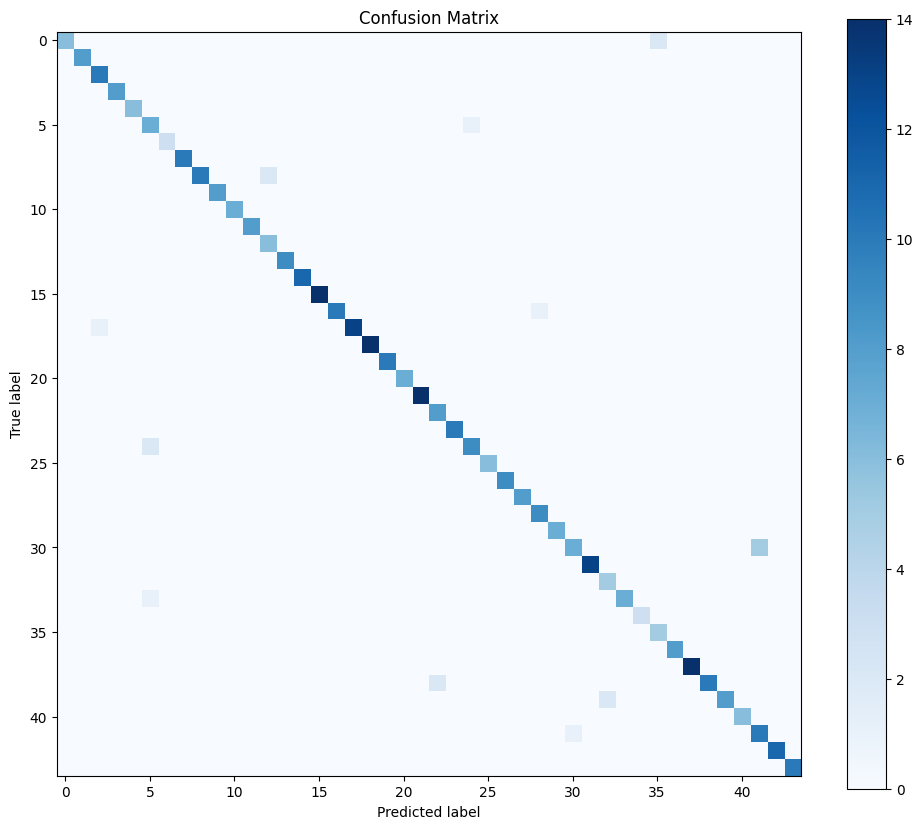

In [12]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [13]:
torch.save(model.state_dict(), "dinov2_finetuned.pt")
print("Model kaydedildi.")

Model kaydedildi.


Test Accuracy: 95.02%


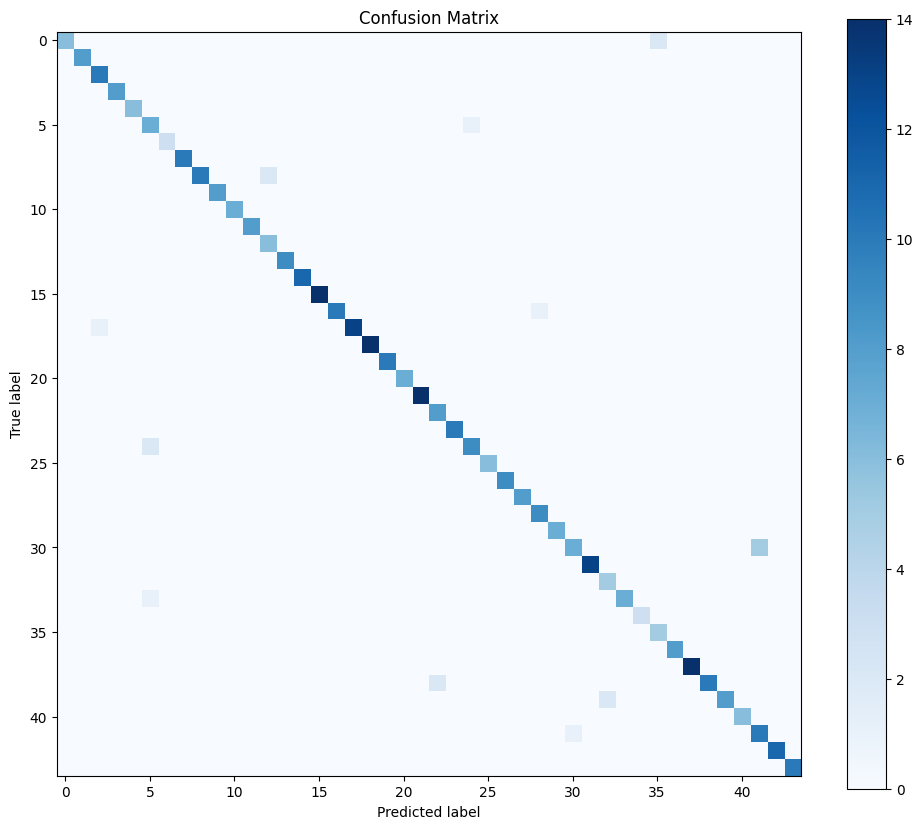

In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Parametreler
DATA_DIR = "/content/drive/MyDrive/Dinov2Demo/datasetv2"
BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_CLASSES = 44
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Sadece test için temel transform
test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Dataset ve test split (Burada aynı split ile kullandığından emin ol: random_split için seed kullan!)
full_dataset = datasets.ImageFolder(DATA_DIR, transform=test_transforms)
data_len = len(full_dataset)
val_len = int(0.15 * data_len)
test_len = int(0.15 * data_len)
train_len = data_len - val_len - test_len
# Use the same seed as in cell 30zPUr9DLYBN for consistent split
train_set, val_set, test_set = random_split(full_dataset, [train_len,val_len,test_len],
                                            generator=torch.Generator().manual_seed(42))

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Reuse the already loaded and fine-tuned model
model.eval()

# Test
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        # Access the logits attribute from the model output
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [17]:
# Kategorilerin isim listesini almak için:
label_names = dataset.classes
import json
with open('label_names.json', 'w') as f:
    json.dump(label_names, f)